## Customer Segmentation with RFM analysis and KMeans Clustering

[Data Preprocessing](#data-preprocessing)

#### Importing the Necessary Libraries

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#### Loading the dataset

In [123]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
data_frame = pd.read_excel(url)

#### Data Preprocessing

In [124]:
data_frame.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [125]:
data_frame.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [126]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [127]:
# Chcking for Missing Values in each column
data_frame.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [128]:
# Dropping all the rows with a missing value in their 'CustomerID' column.
data_frame.dropna(subset=['CustomerID'], inplace=True) 

In [129]:
# Checking if all the rows with the missing values in the 'CustomerID' column have been removed from the dataframe.
data_frame.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [130]:
# filtering the data to select only the rows with non-negative 'Quantity' & 'UnitPrice'
data_frame = data_frame[  ( data_frame['Quantity'] > 0 ) & (data_frame['UnitPrice'] > 0)  ]


In [131]:
# checking if non-negative values have been removed
data_frame.describe()


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,397884.000000,397884,397884.000000,397884.000000
mean,12.988238,2011-07-10 23:41:23.511023360,3.116488,15294.423453
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000
std,179.331775,NaN,22.097877,1713.141560


In [132]:
# Converting 'CustomerID' into an int
data_frame['CustomerID'] = data_frame['CustomerID'].astype(int)

# verifying the data type conversion has been successful
print(data_frame.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object


#### RFM Analysis

In [133]:
# Calculating the total price of each order
data_frame['TotalPrice'] = data_frame['Quantity'] * data_frame['UnitPrice']
print(data_frame['TotalPrice'].head())

0    15.30
1    20.34
2    22.00
3    20.34
4    20.34
Name: TotalPrice, dtype: float64


In [134]:
# Creating a reference date a day later than the date of the most recent transcation data. This date will serve as our refernce point for performing the 'Recency' analysis.
referance_date = max(data_frame['InvoiceDate']) + pd.DateOffset(days=1)
print(referance_date)

2011-12-10 12:50:00


In [135]:
# Computing Recency, Frequency and Monetary values for each customer
rfm = data_frame.groupby('CustomerID').agg(
    {
        'InvoiceDate': lambda x : ( referance_date - x.max() ).days,
        'InvoiceNo': 'nunique',
        'TotalPrice': "sum"
    }
)

print(rfm.head())

# renaming the columns
rfm.rename( columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency','TotalPrice':'Monetary'}, inplace=True )
print(rfm.head())

            InvoiceDate  InvoiceNo  TotalPrice
CustomerID                                    
12346               326          1    77183.60
12347                 2          7     4310.00
12348                75          4     1797.24
12349                19          1     1757.55
12350               310          1      334.40
            Recency  Frequency  Monetary
CustomerID                              
12346           326          1  77183.60
12347             2          7   4310.00
12348            75          4   1797.24
12349            19          1   1757.55
12350           310          1    334.40


In [136]:
rfm.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


In [137]:
# Segment customers into different bins based on Recency, Frequency and Monetary
recency_bins = [rfm['Recency'].min()-1, 20, 50, 150, 250, rfm['Recency'].max()]
frequency_bins = [rfm['Frequency'].min() - 1, 2, 3, 10, 100, rfm['Frequency'].max()]
monetary_bins = [rfm['Monetary'].min() - 3, 300, 600, 2000, 5000, rfm['Monetary'].max()]
 

In [154]:
# Assigning Scores to each bin
rfm['r_score'] = pd.cut(  rfm['Recency'],bins=recency_bins, labels=range(1,6), include_lowest=True)
# Scaling the values so that 1 means customer has not shopped in a while and then 5 means the customer has recently shopped.
rfm['r_score'] = 5 - rfm['r_score'].astype(int) + 1

rfm['monetary_score'] = pd.cut(rfm['Monetary'], bins=monetary_bins, labels=range(1,6),include_lowest=True ).astype(int)
rfm['frequency_score'] = pd.cut( rfm['Frequency'], bins=frequency_bins, labels=range(1,6), include_lowest=True  ).astype(int)

score_names = [ 'r_score', 'frequency_score','monetary_score' ]
print(rfm[ score_names].head(10) )

            r_score  frequency_score  monetary_score
CustomerID                                          
12346             1                1               5
12347             5                3               4
12348             3                3               3
12349             5                1               3
12350             1                1               2
12352             4                3               4
12353             2                1               1
12354             2                1               3
12355             2                1               2
12356             4                2               4
Recency              int64
Frequency            int64
Monetary           float64
r_score              int64
monetary_score       int64
frequency_score      int64
Cluster              int32
dtype: object


 #### K-Means Clustering

In [155]:
# extracting the scores from rfm
rfm_subset = rfm[ score_names ]

In [156]:
# Using the elbow method to pick the optimal number of clusters
inertia = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k,random_state=42)
    kmeans.fit(rfm_subset)
    inertia.append(kmeans.inertia_)

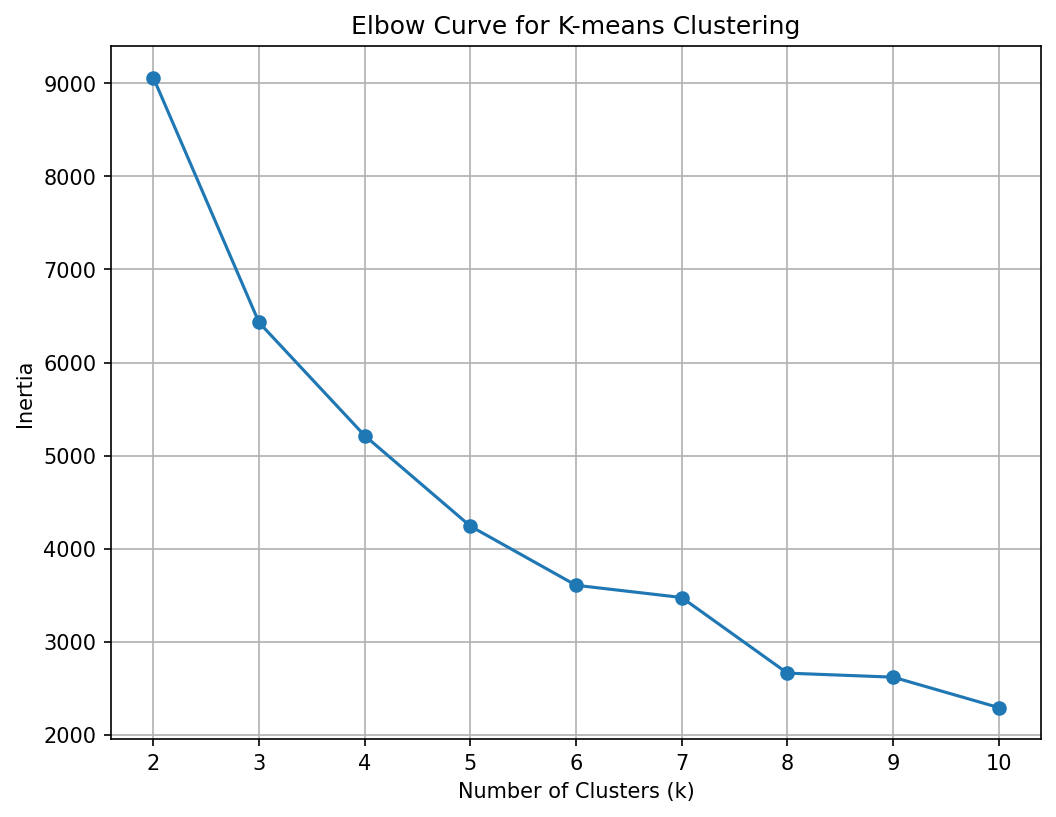

In [159]:
# Plotting the elbow curve
plt.figure(figsize=(8, 6),dpi=150)
plt.plot( range(2,11),inertia, marker='o' )
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

In [164]:
# Perform K-means clustering with best K
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = best_kmeans.fit_predict(rfm_subset)
print(rfm.head())
print(rfm.dtypes)

            Recency  Frequency  Monetary  r_score  monetary_score  \
CustomerID                                                          
12346           326          1  77183.60        1               5   
12347             2          7   4310.00        5               4   
12348            75          4   1797.24        3               3   
12349            19          1   1757.55        5               3   
12350           310          1    334.40        1               2   

            frequency_score  Cluster  
CustomerID                            
12346                     1        1  
12347                     3        2  
12348                     3        1  
12349                     1        3  
12350                     1        0  
Recency              int64
Frequency            int64
Monetary           float64
r_score              int64
monetary_score       int64
frequency_score      int64
Cluster              int32
dtype: object


#### Identifying Customer Segments

In [168]:
# Group by cluster and calculate mean values
cluster_summary = rfm.groupby('Cluster').agg(
    {
        'r_score' : 'mean',
        'frequency_score' : 'mean',
        'monetary_score' : 'mean'
    }
).reset_index()

print(cluster_summary)

   Cluster   r_score  frequency_score  monetary_score
0        0  1.442263         1.061201        1.505774
1        1  3.013043         1.619130        2.820870
2        2  4.550798         3.169086        3.774311
3        3  4.092161         1.103814        1.505297


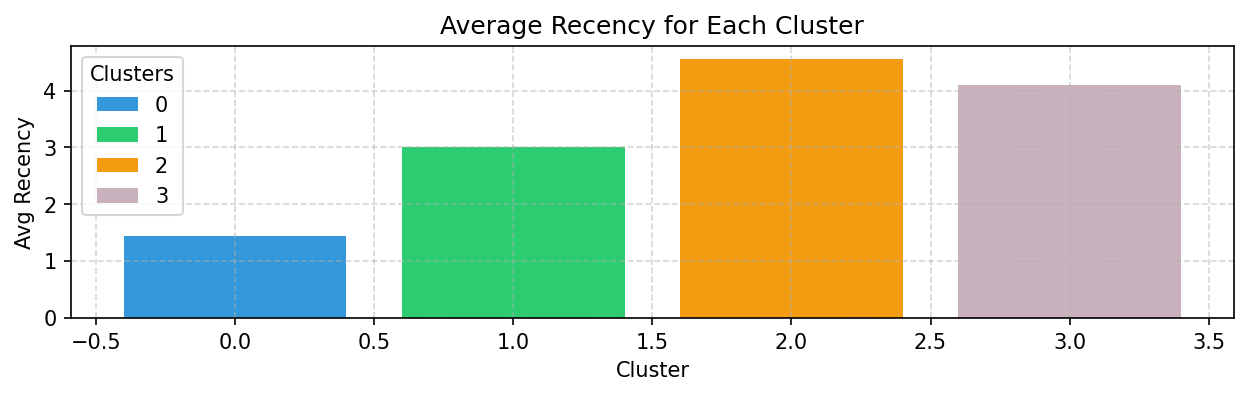

In [177]:
# Visualizing the clusters
colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']
plt.figure( figsize=(10,8),dpi=150)

# plotting recency
plt.subplot(3,1,1)
bars = plt.bar(cluster_summary.index,cluster_summary['r_score'],color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.title('Average Recency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.show()